In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import h5py
import os

In [2]:
def enumerate_connected_devices(context):
    """
    Enumerate the connected Intel RealSense devices
    Parameters:
    -----------
    context 	 	  : rs.context()
                         The context created for using the realsense library
    Return:
    -----------
    connect_device : array
                       Array of enumerated devices which are connected to the PC
    """
    connect_device = []
    for d in context.devices:
        if d.get_info(rs.camera_info.name).lower() != 'platform camera':
            connect_device.append(d.get_info(rs.camera_info.serial_number))
    return connect_device

In [3]:
connected = enumerate_connected_devices(rs.context())

In [4]:
connected

['817412070989', '830112071475', '817412071174', '832112070808']

In [5]:
class Device:
    def __init__(self, pipeline, pipeline_profile):
        self.pipeline = pipeline
        self.pipeline_profile = pipeline_profile

In [6]:
config = rs.config()
resolution_width = 480
resolution_height = 270
framerate = 90
config.enable_stream(rs.stream.infrared, 1, resolution_width, resolution_height, rs.format.y8, framerate)
config.enable_stream(rs.stream.infrared, 2, resolution_width, resolution_height, rs.format.y8, framerate)
# config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

devices = {}
for serial in connected:
    pipeline = rs.pipeline()
    config.enable_device(serial)
    pipeline_profile = pipeline.start(config)

    # Set the acquisition parameters
    sensor = pipeline_profile.get_device().first_depth_sensor()
    sensor.set_option(rs.option.emitter_enabled,1)
    devices[serial] = Device(pipeline, pipeline_profile)


In [16]:
dir(pipeline)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'get_active_profile',
 'poll_for_frames',
 'start',
 'stop',
 'try_wait_for_frames',
 'wait_for_frames']

In [ ]:
# config.disable_all_streams()

In [7]:
frames = {}
for (serial, device) in devices.items():
    streams = device.pipeline_profile.get_streams()
    frameset = rs.composite_frame(rs.frame())
    frameset = device.pipeline.poll_for_frames()
    if frameset.size() == len(streams):
        frames[serial] = {}
        for stream in streams:
            if (rs.stream.infrared == stream.stream_type()):
                frame = frameset.get_infrared_frame(stream.stream_index())
                key_ = (str(stream.stream_type()), stream.stream_index())
            else:
                frame = frameset.first_or_default(stream.stream_type())
                key_ = str(stream.stream_type())
            frames[serial][key_] = frame

In [8]:
for serial, frame in frames.items():
    print(serial,frame)

817412070989 {('stream.infrared', 1): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDA40>, ('stream.infrared', 2): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDA78>}
830112071475 {('stream.infrared', 1): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FD998>, ('stream.infrared', 2): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FD928>}
817412071174 {('stream.infrared', 1): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDAB0>, ('stream.infrared', 2): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDA08>}
832112070808 {('stream.infrared', 1): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDB20>, ('stream.infrared', 2): <pyrealsense2.pyrealsense2.video_frame object at 0x00000274CE3FDAE8>}


In [13]:
.shape

(270, 480)

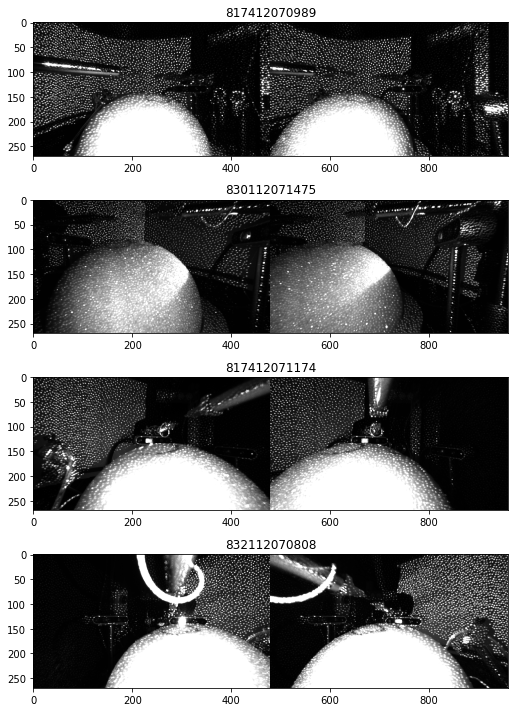

In [15]:
N = len(frames)
fig, ax = plt.subplots(N,1,figsize=(16,10))
cnt=0
for serial, frame in frames.items():
    left = np.asarray(frame[('stream.infrared',1)].get_data())
    right = np.asarray(frame[('stream.infrared',2)].get_data())
    out = np.hstack((left,right))
    ax[cnt].imshow(out, 'gray')
    ax[cnt].set_title(serial)
    cnt+=1
    
plt.tight_layout()
plt.show()

In [ ]:
np.asarray(ir.get_data()).shape

In [ ]:
frames['817412070989'][list(frames['817412070989'].keys())[0]]

In [ ]:
list(frames['817412070989'].keys())[0]

In [ ]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
resolution_width = 480
resolution_height = 270
framerate = 90
config.enable_stream(rs.stream.infrared, 1, resolution_width, resolution_height, rs.format.y8, framerate)
config.enable_stream(rs.stream.infrared, 2, resolution_width, resolution_height, rs.format.y8, framerate)
# config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
# config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
prof = pipeline.start(config)

In [ ]:
dir(config)

In [ ]:
device = prof.get_device()

In [ ]:
ir_sensors = device.query_sensors()[0] # 1 for RGB

In [ ]:
ir_sensors.get_info()

In [ ]:
ir_sensors.is_depth_sensor()

In [ ]:
dir(rs.option.enable_auto_exposure)

In [ ]:
ir_sensors.set_option(rs.option.enable_auto_exposure,0)

### Interesting methods of frame class:

* as_depth_frame
* data
* frame_number
* frame_timestamp_domain
* get_data
* get_depth_frame
* get_frame_metadata
* get_frame_number
* get_frame_timestamp_domain
* get_infrared_frame
* get_timestamp
* timestamp

In [ ]:
def append_to_hdf5(f, name, value, axis=0):
    f[name].resize(f[name].shape[axis]+1, axis=axis)
    f[name][-1]=value

In [ ]:
datadir = r'D:\DATA\JB\realsense\experiment08'
f = h5py.File(os.path.join(datadir, 'tmp.h5'), 'w')
datatype = h5py.special_dtype(vlen=np.dtype('uint8'))
dset = f.create_dataset('left', (0,), maxshape=(None,),dtype=datatype)
dset = f.create_dataset('right', (0,), maxshape=(None,),dtype=datatype)

In [ ]:
f.close()

In [ ]:
n_frames = 100

In [ ]:
frames = pipeline.wait_for_frames()
left = frames.get_infrared_frame(1)
right = frames.get_infrared_frame(2)
if not left or not right:
    pass
left, right = np.asanyarray(left.get_data()), np.asanyarray(right.get_data())

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(left)
ax[1].imshow(right)
plt.show()

In [ ]:
# %%timeit
# frames = pipeline.wait_for_frames()
left = frames.get_infrared_frame(1)
right = frames.get_infrared_frame(2)
if not left or not right:
    continue
left, right = np.asanyarray(left.get_data()), np.asanyarray(right.get_data())
ret1, left_jpg = cv2.imencode('.jpg', left, (cv2.IMWRITE_JPEG_QUALITY,80))
ret2, right_jpg = cv2.imencode('.jpg', right, (cv2.IMWRITE_JPEG_QUALITY,80))
if ret1 and ret2:
    append_to_hdf5(f, 'left', left_jpg.squeeze())
    append_to_hdf5(f, 'right', right_jpg.squeeze())

In [ ]:
f.close()

In [ ]:
with h5py.File(os.path.join(datadir, 'tmp.h5'), 'r') as f:
    print(f['left'][:])

In [ ]:
decoded = cv2.imdecode(left_jpg,0)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(left)
ax[1].imshow(decoded)
plt.show()

In [ ]:
pipeline.stop()

# preview only!

In [ ]:
dir(ir_sensors)

In [ ]:
dir(rs.option)

Example getting options

In [ ]:
exp = ir_sensors.get_option(rs.option.exposure)
lims = ir_sensors.get_option_range(rs.option.exposure)
print('Exposure: {0}'.format(exp))
print('Min: {0} Max: {1} Default: {2} Step: {3}'.format(lims.min, lims.max, 
                                                       lims.default, lims.step))

In [ ]:
ir_sensors.get_option(rs.option.gain)

Example setting options

In [ ]:
ir_sensors.set_option(rs.option.enable_auto_exposure,0)
ir_sensors.set_option(rs.option.exposure,500)
ir_sensors.set_option(rs.option.gain,32)

In [ ]:
# %%timeit
# frames = pipeline.wait_for_frames()
cv2.namedWindow('Infrared', cv2.WINDOW_AUTOSIZE)
while True:
    frames = pipeline.wait_for_frames()
    left = frames.get_infrared_frame(1)
    right = frames.get_infrared_frame(2)
    if not left or not right:
        continue
    left, right = np.asanyarray(left.get_data()), np.asanyarray(right.get_data())
    stacked = np.hstack((left,right))
    cv2.imshow('Infrared', stacked)
    key = cv2.waitKey(10)
    if key==27:
        cv2.destroyAllWindows()
        break